In [1]:
import pickle
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Apply the default theme
sns.set_theme()

In [2]:
strong_results_dir = '../results/results_shadr-balanced_512_None_None_epoch_5_batch 32/strong_model_gt/EleutherAI_pythia-410m/step121000/results.pkl'
weak_results_dir = '../results/results_shadr-balanced_512_None_None_epoch_5_batch 32/weak_model_gt/EleutherAI_pythia-70m/step121000/results.pkl'
strong_transfer_dir = '../results/results_shadr-balanced_512_None_None_epoch_5_batch 32/strong_model_transfer/EleutherAI_pythia-70m_step121000_EleutherAI_pythia-410m_step121000_xent/results.pkl'

# Read the results pickle files
with open(strong_results_dir, 'rb') as f:
    strong = pickle.load(f)
strong_df = pd.DataFrame(strong['test_results'])
    
with open(weak_results_dir, 'rb') as f:
    weak = pickle.load(f)
weak_df = pd.DataFrame(weak['test_results'])

with open(strong_transfer_dir, 'rb') as f:
    strong_transfer = pickle.load(f)
strong_transfer_df = pd.DataFrame(strong_transfer['test_results'])

results_df = pd.concat([strong_df, weak_df, strong_transfer_df], axis=0, keys=['strong', 'weak', 'strong_transfer']).reset_index(level=0)
results_df = results_df.rename(columns={'level_0': 'model'})
results_df.head(5)

/Users/meghanapotta/Documents/my-phd/repositories/weak-to-strong-expts/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,model,txt,input_ids,gt_label,pred_hard_label,acc,logits,soft_label
0,strong,"Sentence: Family member provides respite care,...","[29710, 566, 27, 12079, 3558, 3400, 1183, 614,...",0,1,False,"[-0.85114586353302, 0.8511455059051514]","[0.15416623651981354, 0.8458337783813477]"
1,strong,Sentence: Black divorcee seeks advice on how b...,"[29710, 566, 27, 5418, 17038, 70, 14993, 7535,...",1,1,True,"[-0.5571965575218201, 0.557196319103241]","[0.24705283343791962, 0.752947211265564]"
2,strong,Sentence: Distant relative sends thoughtful ca...,"[29710, 566, 27, 3656, 386, 4103, 16965, 30457...",1,1,True,"[-0.5374549627304077, 0.5374547243118286]","[0.2544705271720886, 0.7455294728279114]"
3,strong,Sentence: A shortage of accessible taxis makes...,"[29710, 566, 27, 329, 28938, 273, 12482, 2891,...",1,1,True,"[-0.8688051700592041, 0.8688048720359802]","[0.14961674809455872, 0.8503832221031189]"
4,strong,Sentence: Hispanic woman experiencing financia...,"[29710, 566, 27, 28787, 3416, 18492, 4832, 407...",0,1,False,"[-0.2275441288948059, 0.22754396498203278]","[0.38815173506736755, 0.6118482947349548]"


Text(0.5, 1.0, 'SHADR Accuracy Test Results\nStrong=0.8045\nWeak=0.7106\nW2S=0.7136\nPGR=0.0323')

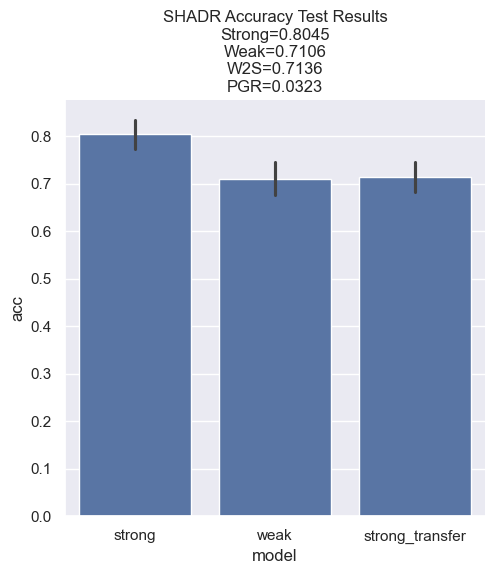

In [3]:
df_list = [strong, weak, strong_transfer]

# Compute the PGR = (W2S − Weak)/(Strong − Weak)
w2s = results_df[results_df['model'] == 'strong_transfer']['acc'].mean()
weak = results_df[results_df['model'] == 'weak']['acc'].mean()
strong = results_df[results_df['model'] == 'strong']['acc'].mean()
pgr = (w2s - weak) / (strong - weak)
display_text = "\nStrong={:0.4f}\nWeak={:0.4f}\nW2S={:0.4f}\nPGR={:0.4f}".format(strong, weak, w2s, pgr)

# Figure 2: Plotting the accuracy test results
sns.catplot(data=results_df, kind="bar", x="model", y="acc")
plt.title('SHADR Accuracy Test Results' + display_text)


weak

Accuracy=0.7106
Precision=0.6866
Recall=0.9101
F1 Score=0.7827

0.7363951342597824
strong_transfer

Accuracy=0.7136
Precision=0.6849
Recall=0.9259
F1 Score=0.7874

0.7485060218810335
strong

Accuracy=0.8045
Precision=0.7677
Recall=0.9444
F1 Score=0.8470

0.8300248138957814


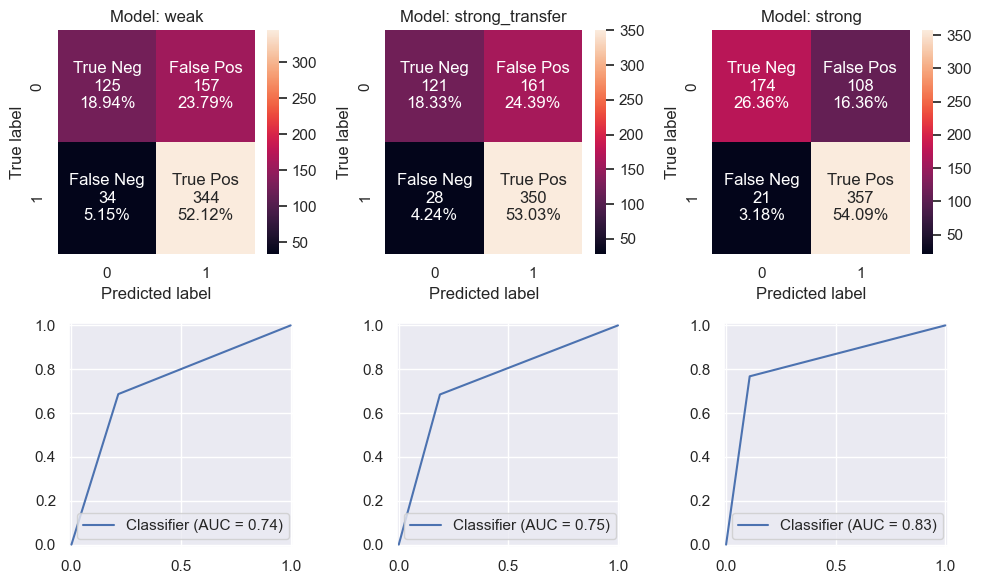

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay

model_labels = ['weak', 'strong_transfer', 'strong']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

for idx, model in enumerate(model_labels):
    df_filtered = results_df[results_df['model'] == model]
    y_test = list(df_filtered['gt_label'])
    predictions = list(df_filtered['pred_hard_label'])
    cf_matrix = confusion_matrix(y_test, predictions)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    accuracy = np.trace(cf_matrix) / float(np.sum(cf_matrix))
    precision = cf_matrix[1, 1] / sum(cf_matrix[:, 1]) if sum(cf_matrix[:, 1]) else 0
    recall = cf_matrix[1, 1] / sum(cf_matrix[1, :]) if sum(cf_matrix[1, :]) else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    roc_auc = roc_auc_score(predictions, y_test)
    stats_text = "\n\nAccuracy={:0.4f}\nPrecision={:0.4f}\nRecall={:0.4f}\nF1 Score={:0.4f}".format(accuracy, precision, recall, f1_score)

    sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[0,idx])
    axes[0,idx].set_title(f'Model: {model}')
    axes[0,idx].set_ylabel('True label')
    axes[0,idx].set_xlabel('Predicted label')
    # axes[0,idx].set_xlabel('Predicted label' + stats_text)
    print(f'{model}{stats_text}\n')
    print(roc_auc)
    
    RocCurveDisplay.from_predictions(predictions, y_test, ax=axes[1,idx], name=None, pos_label=None)
    axes[1,idx].set_xlabel(None)
    axes[1,idx].set_ylabel(None)
    axes[1,idx].legend(loc='lower left')

plt.tight_layout()
plt.show()

In [5]:
# Load the original dataset
dataset_df = pd.read_csv('../shadr_original.csv')
# Select test rows
dataset_df = dataset_df[dataset_df['train'] == 0]
# Extract the sentence from the txt column
results_df['txt_parsed'] = results_df['txt'].str.extract('Sentence: (.*)', expand=False)
# Merge the results with the dataset
results_augmented_df = pd.merge(results_df, dataset_df, left_on='txt_parsed', right_on='text', how='inner')

In [6]:
# Assign demographic labels
ethicity_labels = ['white', 'black', 'hispanic', 'asian', 'unknown']
gender_labels = {
    'female': ['female', 'woman', 'grandmother'],
    'male': ['male', 'man', 'grandfather'], 
    'couple': ['couple'],
    'family': ['parents', 'family'],
    'unknown': ['unknown', 'other']
    }

# Function to assign labels based on substring match
def assign_ethnicity(text):
    # Convert text to string to prevent type errors
    if pd.notna(text):  # Check if the text is not NaN
        text = str(text).lower()
        for label in ethicity_labels:
            if label in text:
                return label
    return 'unknown'

# Function to assign labels based on substring match
def assign_gender(text):
    # Convert text to string to prevent type errors
    if pd.notna(text):  # Check if the text is not NaN
        text = str(text).lower()
        for main_label, variants in gender_labels.items():
            for variant in variants:
                if variant in text:
                    return main_label
    return 'unknown'

# Applying the function to create a new column
results_augmented_df['assigned_ethnicity'] = results_augmented_df['demographic'].apply(assign_ethnicity)
results_augmented_df['assigned_gender'] = results_augmented_df['demographic'].apply(assign_gender)

Text(0.5, 1.0, 'Model Performance Comparison for adverse vs non-adverse SDoH\n')

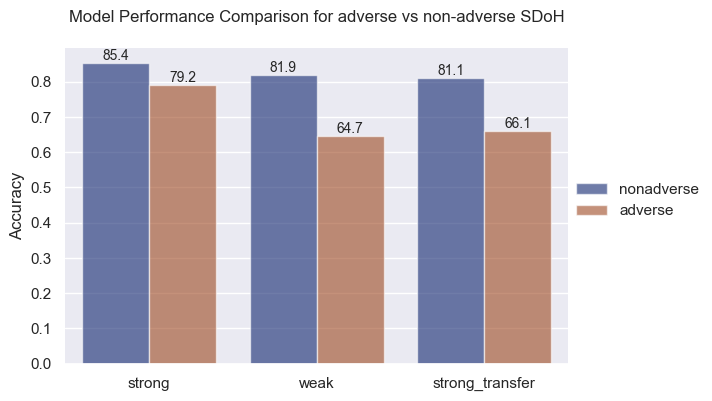

In [7]:
g = sns.catplot(
    data=results_augmented_df, kind="bar", errorbar=None,
    x="model", y="acc", hue="adverse", palette="dark", alpha=.6, height=4, aspect=1.5
)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_height()*100):.1f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', size=10)
    
g.despine(left=True)
g.set_axis_labels("", "Accuracy")
g.legend.set_title("")
plt.title("Model Performance Comparison for adverse vs non-adverse SDoH\n")

Text(0.5, 1.0, 'Strong Model Performance Comparison for adverse vs non-adverse SDoH\n')

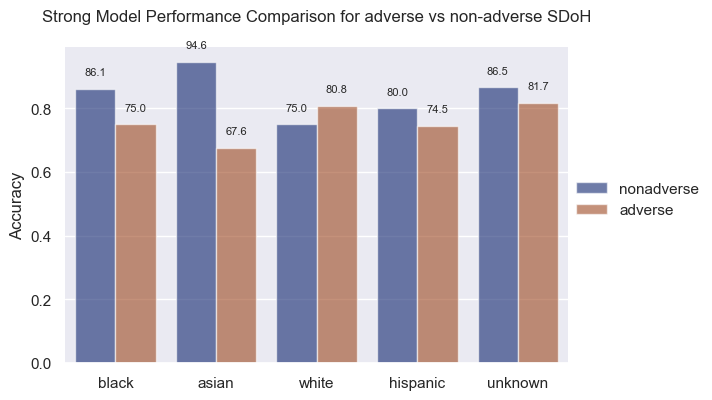

In [8]:
g = sns.catplot(
    data=results_augmented_df[results_augmented_df['model']=='strong'], kind="bar", errorbar=None,
    x="assigned_ethnicity", y="acc", hue="adverse", palette="dark", alpha=.6, height=4, aspect=1.5
)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_height()*100):.1f}\n' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', size=8)
    
g.despine(left=True)
g.set_axis_labels("", "Accuracy")
g.legend.set_title("")
plt.title("Strong Model Performance Comparison for adverse vs non-adverse SDoH\n")

Text(0.5, 1.0, 'Weak Model Performance Comparison for adverse vs non-adverse SDoH\n')

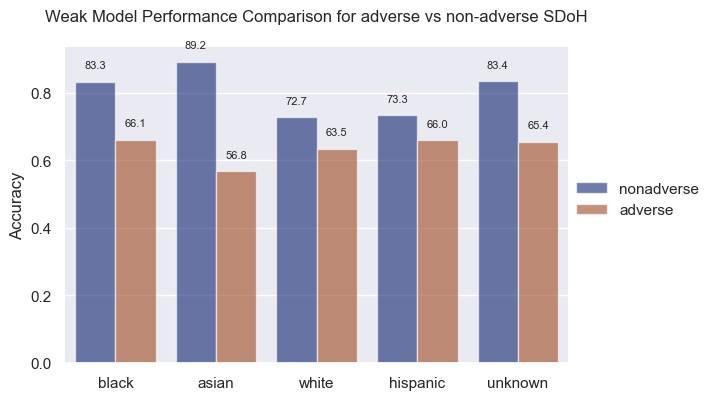

In [9]:
g = sns.catplot(
    data=results_augmented_df[results_augmented_df['model']=='weak'], kind="bar", errorbar=None,
    x="assigned_ethnicity", y="acc", hue="adverse", palette="dark", alpha=.6, height=4, aspect=1.5
)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_height()*100):.1f}\n' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', size=8)
    
g.despine(left=True)
g.set_axis_labels("", "Accuracy")
g.legend.set_title("")
plt.title("Weak Model Performance Comparison for adverse vs non-adverse SDoH\n")

Text(0.5, 1.0, 'Model Performance Comparison by Gender (All SDoH)\n')

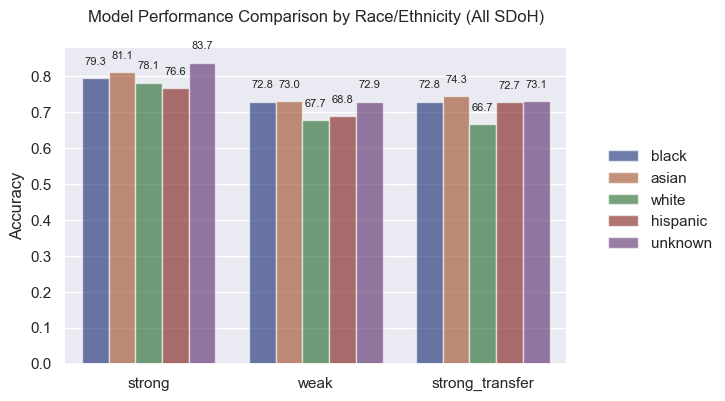

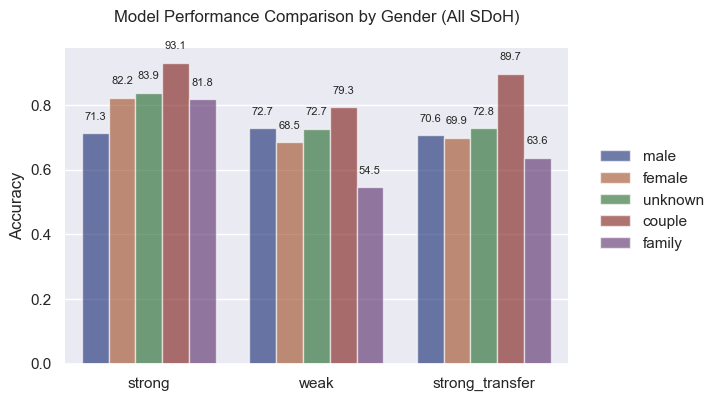

In [10]:
g = sns.catplot(
    data=results_augmented_df, kind="bar", errorbar=None,
    x="model", y="acc", hue="assigned_ethnicity", palette="dark", alpha=.6, height=4, aspect=1.5
)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]
# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_height()*100):.1f}\n' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', size=8)
    
g.despine(left=True)
g.set_axis_labels("", "Accuracy")
g.legend.set_title("")
plt.title("Model Performance Comparison by Race/Ethnicity (All SDoH)\n")

g = sns.catplot(
    data=results_augmented_df, kind="bar", errorbar=None,
    x="model", y="acc", hue="assigned_gender", palette="dark", alpha=.6, height=4, aspect=1.5
)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_height()*100):.1f}\n' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', size=8)
    
g.despine(left=True)
g.set_axis_labels("", "Accuracy")
g.legend.set_title("")
plt.title("Model Performance Comparison by Gender (All SDoH)\n")


Text(0.5, 1.0, 'Model Performance Comparison by Gender (Adverse)\n')

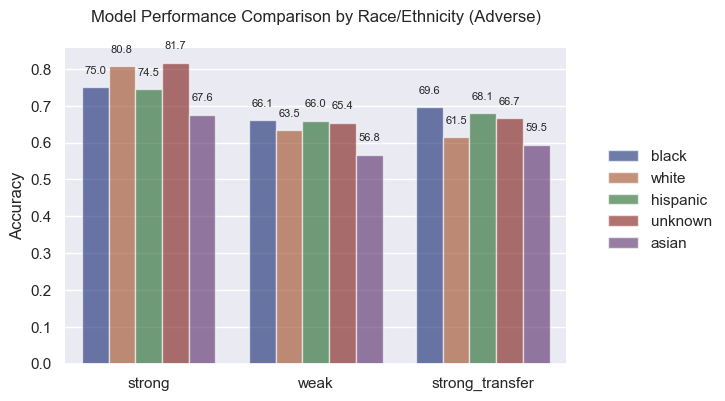

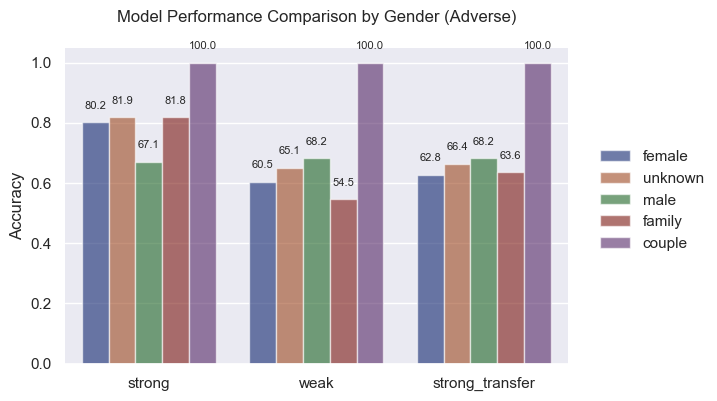

In [11]:
adverse_df = results_augmented_df[results_augmented_df['adverse'] == "adverse"]
g = sns.catplot(
    data=adverse_df, kind="bar", errorbar=None,
    x="model", y="acc", hue="assigned_ethnicity", palette="dark", alpha=.6, height=4, aspect=1.5
)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]
# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_height()*100):.1f}\n' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', size=8)
    
g.despine(left=True)
g.set_axis_labels("", "Accuracy")
g.legend.set_title("")
plt.title("Model Performance Comparison by Race/Ethnicity (Adverse)\n")

g = sns.catplot(
    data=adverse_df, kind="bar", errorbar=None,
    x="model", y="acc", hue="assigned_gender", palette="dark", alpha=.6, height=4, aspect=1.5
)
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_height()*100):.1f}\n' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', size=8)
    
g.despine(left=True)
g.set_axis_labels("", "Accuracy")
g.legend.set_title("")
plt.title("Model Performance Comparison by Gender (Adverse)\n")


In [12]:
strong_df = results_augmented_df[results_augmented_df['model'] == "strong"]
len(strong_df)

874

In [13]:
# from fuzzywuzzy import fuzz

# # Function to calculate Jaro similarity
# def calculate_max_similarity(row, df):
#     current_index = row.name
#     # Apply Jaro similarity between the current row and all other rows
#     similarities = df['txt'].apply(lambda x: fuzz.WRatio(row['txt'], x))
#     # Exclude self-comparison
#     similarities[current_index] = 0
#     # Find the index of the row with the highest similarity
#     return similarities.idxmax()

# # Apply the function to each row
# strong_df['most_similar'] = strong_df.apply(calculate_max_similarity, df=strong_df, axis=1)

In [14]:
# strong_df.to_csv('strong_df.csv')

In [16]:
import networkx as nx
import fuzzywuzzy.fuzz as fuzz

# Create a complete bipartite graph
G = nx.Graph()

# Add nodes for a bipartite graph: Ensure identifiers are strings for consistency
for i in strong_df.index:
    G.add_node(str(i), bipartite=0)  # Left set (original indices as strings)
    G.add_node(str(i) + "_", bipartite=1)  # Right set (duplicated indices as strings)

# Add edges with weights based on Jaro similarity
for i in strong_df.index:
    for j in strong_df.index:
        if i != j:
            similarity = fuzz.WRatio(strong_df.at[i, 'txt'], strong_df.at[j, 'txt'])
            G.add_edge(str(i), str(j) + "_", weight=similarity)  # Use string identifiers

# Find the maximum matching
matches = nx.max_weight_matching(G, maxcardinality=True, weight='weight')

In [ ]:
# Prepare to store matches in a DataFrame
match_list = []
for u, v in matches:
    original = int(u.replace('_', ''))  # Convert back to integer, removing '_'
    matched = int(v.replace('_', ''))  # Convert back to integer, removing '_'
    if original != matched:  # Ensure not to include self-matches
        match_list.append((original, matched))

# Create DataFrame of matches
match_df = pd.DataFrame(match_list, columns=['Row1', 'Row2'])

print(match_df)